<a href="https://colab.research.google.com/github/YoonSungLee/AI-Innovation-Square_Vision/blob/master/Day%2019_U-Net%20Softmax%20activation%20%EC%8B%A4%EC%8A%B5/Mnet_tutorial_softmax1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

The U-Net model is a simple fully  convolutional neural network that is used for binary segmentation i.e foreground and background pixel-wise classification. Mainly, it consists of two parts. 

*   Contracting Path: we apply a series of conv layers and downsampling layers  (max-pooling) layers to reduce the spatial size 
*   Expanding Path: we apply a series of upsampling layers to reconstruct the spatial size of the input. 

The two parts are connected using a concatenation layers among different levels. This allows learning different features at different levels. At the end we have a simple conv 1x1 layer to reduce the number of channels to 1. 


![alt text](https://blog.playment.io/wp-content/uploads/2018/03/Screen-Shot-2018-09-05-at-3.00.03-PM.png)

# Imports

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from keras.layers import  Dropout, Activation
from keras.optimizers import Adam, SGD
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras.losses import binary_crossentropy, categorical_crossentropy
from keras.utils import plot_model, to_categorical
import tensorflow as tf
import glob
import random
import cv2
from random import shuffle

Using TensorFlow backend.


# Dataset

We will use the The Oxford-IIIT Pet Dataset. It contains 37 classes of dogs and cats with around 200 images per each class. The dataset contains labels as bounding boxes and segmentation masks. The total number of images in the dataset is a little more than 7K. 

![alt text](http://www.robots.ox.ac.uk/~vgg/data/pets/pet_annotations.jpg)

Download the images/masks and unzip the files 

In [0]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xvzf images.tar.gz && tar -xvzf annotations.tar.gz
!rm  images/*.mat

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
annotations/trimaps/pomeranian_180.png
annotations/trimaps/._pomeranian_181.png
annotations/trimaps/pomeranian_181.png
annotations/trimaps/._pomeranian_182.png
annotations/trimaps/pomeranian_182.png
annotations/trimaps/._pomeranian_183.png
annotations/trimaps/pomeranian_183.png
annotations/trimaps/._pomeranian_184.png
annotations/trimaps/pomeranian_184.png
annotations/trimaps/._pomeranian_185.png
annotations/trimaps/pomeranian_185.png
annotations/trimaps/._pomeranian_186.png
annotations/trimaps/pomeranian_186.png
annotations/trimaps/._pomeranian_187.png
annotations/trimaps/pomeranian_187.png
annotations/trimaps/._pomeranian_188.png
annotations/trimaps/pomeranian_188.png
annotations/trimaps/._pomeranian_189.png
annotations/trimaps/pomeranian_189.png
annotations/trimaps/._pomeranian_19.png
annotations/trimaps/pomeranian_19.png
annotations/trimaps/._pomeranian_190.png
annotations/trimaps/pomeranian_190.png
annotations/trimaps/._pomeranian_191.png
annota

Note that we have two foulders. The first one is `images` which contains the raw images and annotation which contains the masks as a `binary` foulder image.

# Generators

In [0]:
def image_generator(files, batch_size = 32, sz = (256, 256)):
  
  while True: 
    
    #extract a random batch
    batch = np.random.choice(files, size = batch_size)
    
    #variables for collecting batches of inputs and outputs
    batch_x = [] # inputs : image
    batch_y = [] # outputs : mask
    
    
    for f in batch:

        #get the masks. Note that masks are png files
        mask = Image.open(f'annotations/trimaps/{f[:-4]}.png')
        mask = np.array(mask.resize(sz))


        #preprocess the mask 
        mask[mask >= 2] = 0 # background
        mask[mask != 0 ] = 1 # object
        
        batch_y.append(mask)

        #preprocess the raw images 
        raw = Image.open(f'images/{f}')
        raw = raw.resize(sz)
        raw = np.array(raw)

        #check the number of channels because some of the images are RGBA or GRAY
        if len(raw.shape) == 2: # if the image is GRAY scale
          raw = np.stack((raw,)*3, axis=-1) # 1 channel GRAY image change to 3 channels GRAY image

        else:
          raw = raw[:,:,0:3]

        batch_x.append(raw) # raw.shape = (256, 256, 3)

    #preprocess a batch of images and masks 
    batch_x = np.array(batch_x)/255. # batch_x.shape = (N, 256, 256, 3)
    batch_y = np.array(batch_y)

    batch_y = to_categorical(batch_y)

    yield (batch_x, batch_y)


### Python의 yield 키워드 알아보기
* https://tech.ssut.me/what-does-the-yield-keyword-do-in-python/

In [0]:
batch_size = 4

all_files = os.listdir('images')
shuffle(all_files)

split = int(0.95 * len(all_files))

#split into training and testing
train_files = all_files[0:split]
test_files  = all_files[split:]

train_generator = image_generator(train_files, batch_size = batch_size)
test_generator  = image_generator(test_files, batch_size = batch_size)

In [0]:
x, y= next(train_generator)

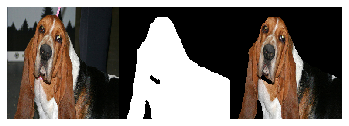

In [0]:
plt.axis('off')
img = x[0]
msk = y[0]
msk = msk[:,:,1].squeeze()
msk = np.stack((msk,)*3, axis=-1)

plt.imshow( np.concatenate([img, msk, img*msk], axis = 1))

# IoU metric

The intersection over union (IoU) metric is a simple metric used to evaluate the performance of a segmentation algorithm. Given two masks $x_{true}, x_{pred}$ we evaluate 

$$IoU = \frac{y_{true} \cap y_{pred}}{y_{true} \cup y_{pred}}$$

In [0]:
def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

# bce_dice_loss

In [0]:
def dice_coef(y_true, y_pred, smooth=1):
    y_pred = K.argmax(y_pred, axis=-1)
    y_true = y_true[:,:,:,1]
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    y_true_f = K.cast(y_true_f, 'float32')
    y_pred_f = K.cast(y_pred_f, 'float32')

    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_loss(y_true, y_pred):
    smooth = 1.
    y_pred = K.argmax(y_pred, axis=-1)
    y_true = y_true[:,:,:,1]

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    y_true_f = K.cast(y_true_f, 'float32')
    y_pred_f = K.cast(y_pred_f, 'float32')

    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

# loss function definition
def bce_dice_loss(y_true, y_pred):
    return categorical_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

# Model

<img src="https://i.imgur.com/6aIaOJn.png" width="100%">


<img src="https://i.imgur.com/ruJATvR.png" width="100%">


In [0]:
def mnet(sz = (256, 256, 3)):
  x = Input(sz)
  inputs = x
  
  #Contracting layers
  nKernels = 4  # training time error로 인해 임시 축소(기존 nKernels = 8)
  layers = [] # for skip connection

  # Level 2 (128, 128, 3)
  L_Reg_1 = MaxPooling2D((2,2))(x)
  # Level 3 (64, 64, 3)
  L_Reg_2 = MaxPooling2D((2,2))(L_Reg_1)
  # Level 4 (32, 32, 3)
  L_Reg_3 = MaxPooling2D((2,2))(L_Reg_2)
  # Level 5 (16, 16, 3)
  L_Reg_4 = MaxPooling2D((2,2))(L_Reg_3)
  # Level 6 (8, 8, 3)
  L_Reg_5 = MaxPooling2D((2,2))(L_Reg_4)
  # BottleNeck (4, 4, 3)
  L_Reg_6 = MaxPooling2D((2,2))(L_Reg_5)

  # level_1 (256, 256, 8)
  # level + layer
  layer11 = Conv2D(nKernels, 3, activation='relu', padding='same', kernel_initializer='he_normal', use_bias=False) (x)
  layer11 = BatchNormalization()(layer11)
  layer12 = Conv2D(nKernels*2, 3, activation='relu', padding='same', kernel_initializer='he_normal', use_bias=False) (layer11)
  layer12 = BatchNormalization()(layer12)
  layers.append(layer12) # for skip connection
  layer13 = MaxPooling2D() (layer12)
  
  # level_2 (128, 128, 16)
  # layer13 (128, 128, 16), L_Reg_1 (128, 128, 3) --> (128, 128, 19)
  layer13 = Concatenate(axis=3)([L_Reg_1, layer13])
  layer21 = Conv2D(nKernels*2, 3, activation='relu', padding='same', kernel_initializer='he_normal', use_bias=False) (layer13)
  layer21 = BatchNormalization()(layer21)
  layer22 = Conv2D(nKernels*4, 3, activation='relu', padding='same', kernel_initializer='he_normal', use_bias=False) (layer21)
  layer22 = BatchNormalization()(layer22)
  layers.append(layer22) # for skip connection
  layer23 = MaxPooling2D() (layer22)

  # level_3 (64, 64, 32)
  # layer23 (64, 64, 32), L_Reg_2 (64, 64, 3) --> (64, 64, 35)
  layer23 = Concatenate(axis=3)([L_Reg_2, layer23])
  layer31 = Conv2D(nKernels*4, 3, activation='relu', padding='same', kernel_initializer='he_normal', use_bias=False) (layer23)
  layer31 = BatchNormalization()(layer31)
  layer32 = Conv2D(nKernels*8, 3, activation='relu', padding='same', kernel_initializer='he_normal', use_bias=False) (layer31)
  layer32 = BatchNormalization()(layer32)
  layers.append(layer32) # for skip connection
  layer33 = MaxPooling2D() (layer32)

  # level_4 (32, 32, 64)
  layer33 = Concatenate(axis=3)([L_Reg_3, layer33])
  layer41 = Conv2D(nKernels*8, 3, activation='relu', padding='same', kernel_initializer='he_normal', use_bias=False) (layer33)
  layer41 = BatchNormalization()(layer41)
  layer42 = Conv2D(nKernels*16, 3, activation='relu', padding='same', kernel_initializer='he_normal', use_bias=False) (layer41)
  layer42 = BatchNormalization()(layer42)
  layers.append(layer42) # for skip connection
  layer43 = MaxPooling2D() (layer42)

  # level_5 (16, 16, 128)
  layer43 = Concatenate(axis=3)([L_Reg_4, layer43])
  layer51 = Conv2D(nKernels*16, 3, activation='relu', padding='same', kernel_initializer='he_normal', use_bias=False) (layer43)
  layer51 = BatchNormalization()(layer51)
  layer52 = Conv2D(nKernels*32, 3, activation='relu', padding='same', kernel_initializer='he_normal', use_bias=False) (layer51)
  layer52 = BatchNormalization()(layer52)
  layers.append(layer52) # for skip connection
  layer53 = MaxPooling2D() (layer52)

  # level_6 (8, 8, 256)
  layer53 = Concatenate(axis=3)([L_Reg_5, layer53])
  layer61 = Conv2D(nKernels*32, 3, activation='relu', padding='same', kernel_initializer='he_normal', use_bias=False) (layer53)
  layer61 = BatchNormalization()(layer61)
  layer62 = Conv2D(nKernels*64, 3, activation='relu', padding='same', kernel_initializer='he_normal', use_bias=False) (layer61)
  layer62 = BatchNormalization()(layer62)
  layers.append(layer62) # for skip connection
  layer63 = MaxPooling2D() (layer62)
  
  # BottleNeck (4, 4, 512)
  layer63 = Concatenate(axis=3)([L_Reg_6, layer63])
  bottleneck11 = Conv2D(nKernels*64, 3, activation='relu', padding='same', kernel_initializer='he_normal', use_bias=False) (layer63)
  bottleneck11 = BatchNormalization()(bottleneck11)
  bottleneck12 = Conv2D(nKernels*64, 3, activation='relu', padding='same', kernel_initializer='he_normal', use_bias=False) (bottleneck11)
  bottleneck12 = BatchNormalization()(bottleneck12)
  R_leg_6 = bottleneck12
  bottleneck13 = Conv2DTranspose(nKernels*32, 2, strides=(2, 2), padding='same') (bottleneck12)
  # (8, 8, 256)
  level = len(layers) - 1 # 6-1
  layer71 = Concatenate(axis=3)([bottleneck13, layers[level]]) # (B, H, W, C) == axis(0,1,2,3)
  
  # level 7 = level 6
  layer72 = Conv2D(nKernels*32, 3, activation='relu', padding='same', kernel_initializer='he_normal', use_bias=False) (layer71)
  layer72 = BatchNormalization()(layer72)
  layer73 = Conv2D(nKernels*32, 3, activation='relu', padding='same', kernel_initializer='he_normal', use_bias=False) (layer72)
  layer73 = BatchNormalization()(layer73)
  R_leg_5 = layer73
  layer74 = Conv2DTranspose(nKernels*16, 2, strides=(2, 2), padding='same') (layer73)
  level = len(layers) - 2 # 6-2
  layer81 = Concatenate(axis=3)([layer74, layers[level]])
  R_leg_6 = UpSampling2D()(R_leg_6)
  R_leg_5 = Concatenate(axis=3)([R_leg_6, R_leg_5])
  
  # level 8 = level 5
  layer82 = Conv2D(nKernels*16, 3, activation='relu', padding='same', kernel_initializer='he_normal', use_bias=False) (layer81)
  layer82 = BatchNormalization()(layer82)
  layer83 = Conv2D(nKernels*16, 3, activation='relu', padding='same', kernel_initializer='he_normal', use_bias=False) (layer82)
  layer83 = BatchNormalization()(layer83)
  R_leg_4 = layer83
  layer84 = Conv2DTranspose(nKernels*8, 2, strides=(2, 2), padding='same') (layer83)
  level = len(layers) - 3 # 6-3
  layer91 = Concatenate(axis=3)([layer84, layers[level]])
  R_leg_5 = UpSampling2D()(R_leg_5)
  R_leg_4 = Concatenate(axis=3)([R_leg_5, R_leg_4])

  # level 9 = level 4
  layer92 = Conv2D(nKernels*8, 3, activation='relu', padding='same', kernel_initializer='he_normal', use_bias=False) (layer91)
  layer92 = BatchNormalization()(layer92)
  layer93 = Conv2D(nKernels*8, 3, activation='relu', padding='same', kernel_initializer='he_normal', use_bias=False) (layer92)
  layer93 = BatchNormalization()(layer93)
  R_leg_3 = layer93
  layer94 = Conv2DTranspose(nKernels*4, 2, strides=(2, 2), padding='same') (layer93)
  level = len(layers) - 4 # 6-4
  layer101 = Concatenate(axis=3)([layer94, layers[level]])
  R_leg_4 = UpSampling2D()(R_leg_4)
  R_leg_3 = Concatenate(axis=3)([R_leg_4, R_leg_3])

  # level 10 = level 3
  layer102 = Conv2D(nKernels*4, 3, activation='relu', padding='same', kernel_initializer='he_normal', use_bias=False) (layer101)
  layer102 = BatchNormalization()(layer102)
  layer103 = Conv2D(nKernels*4, 3, activation='relu', padding='same', kernel_initializer='he_normal', use_bias=False) (layer102)
  layer103 = BatchNormalization()(layer103)
  R_leg_2 = layer103
  layer104 = Conv2DTranspose(nKernels*2, 2, strides=(2, 2), padding='same') (layer103)
  level = len(layers) - 5 # 6-5
  layer111 = Concatenate(axis=3)([layer104, layers[level]])
  R_leg_3 = UpSampling2D()(R_leg_3)
  R_leg_2 = Concatenate(axis=3)([R_leg_3, R_leg_2])

  # level 11 = level 2
  layer112 = Conv2D(nKernels*2, 3, activation='relu', padding='same', kernel_initializer='he_normal', use_bias=False) (layer111)
  layer112 = BatchNormalization()(layer112)
  layer113 = Conv2D(nKernels*2, 3, activation='relu', padding='same', kernel_initializer='he_normal', use_bias=False) (layer112)
  layer113 = BatchNormalization()(layer113)
  R_leg_1 = layer113
  layer114 = Conv2DTranspose(nKernels, 2, strides=(2, 2), padding='same') (layer113)
  level = len(layers) - 6 # 6-6
  layer121 = Concatenate(axis=3)([layer114, layers[level]])
  R_leg_2 = UpSampling2D()(R_leg_2)
  R_leg_1 = Concatenate(axis=3)([R_leg_2, R_leg_1])
      
  #level 1 = classification 
  R_leg_0 = UpSampling2D()(R_leg_1)
  layer121 = Concatenate(axis=3)([layer121, R_leg_0])
  classification1 = Conv2D(nKernels, 3, activation='relu', padding='same', kernel_initializer='he_normal', use_bias=False) (layer121)
  classification1 = BatchNormalization()(classification1)
  classification2 = Conv2D(nKernels, 3, activation='relu', padding='same', kernel_initializer='he_normal', use_bias=False) (classification1)
  classification2 = BatchNormalization()(classification2)
  outputs = Conv2D(2, 1, activation='softmax') (classification2)
  
  #model creation 
  model = Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer = 'rmsprop', loss = bce_dice_loss, metrics = [dice_coef])
  
  return model

In [0]:
model = mnet()

In [0]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 4)  108         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 4)  16          conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 8)  288         batch_normalization_1[0][0]      
____________________________________________________________________________________________

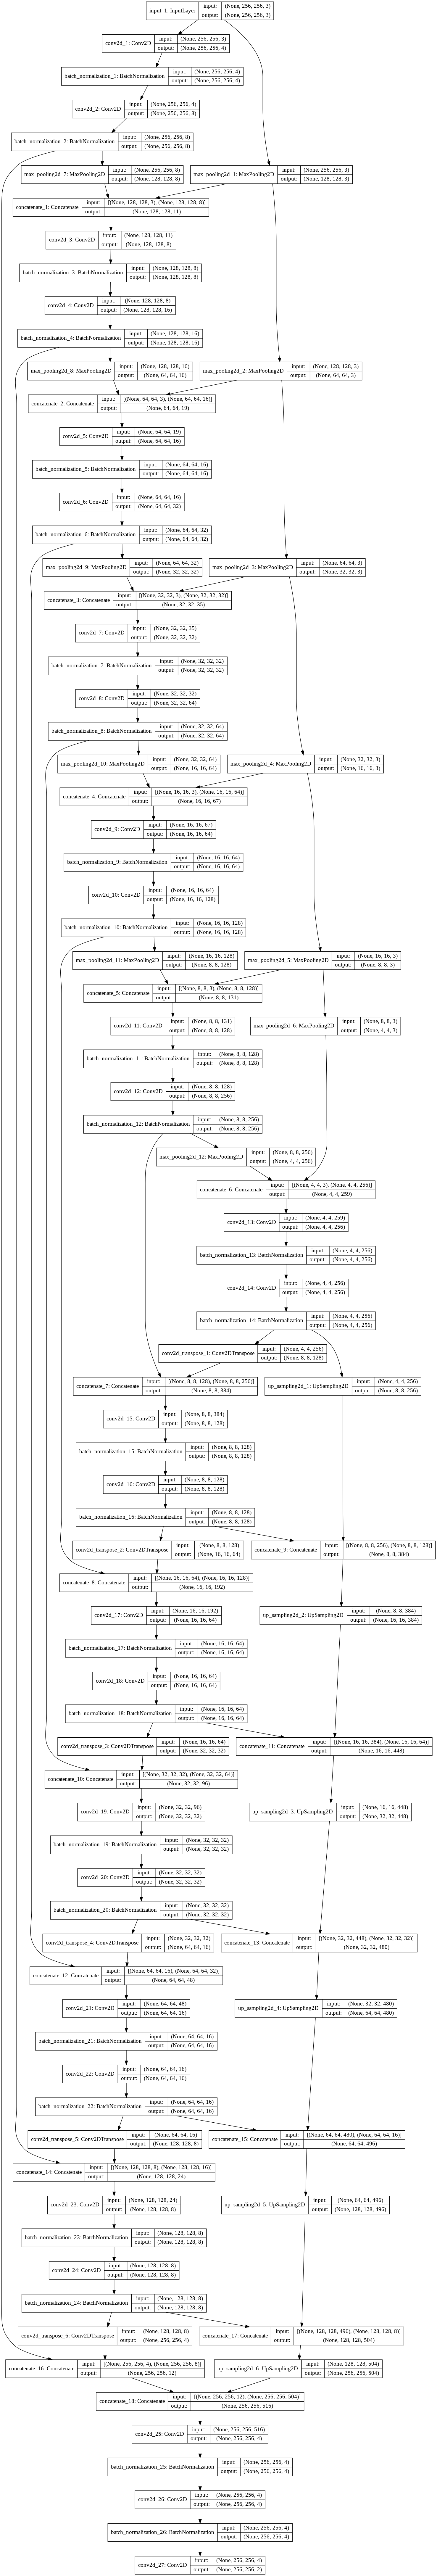

In [0]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Callbacks

Simple functions to save the model at each epoch and show some predictions 

In [0]:
def build_callbacks():
        checkpointer = ModelCheckpoint(filepath='mnet.h5', verbose=0, save_best_only=True, save_weights_only=True)
        callbacks = [checkpointer, PlotLearning()]
        return callbacks

# inheritance for training process plot 
class PlotLearning(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        #self.fig = plt.figure()
        self.logs = []
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('dice_coef'))
        self.val_acc.append(logs.get('val_dice_coef'))
        self.i += 1
        print('i=',self.i,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'),'mean_dsc=',logs.get('dice_coef'),'val_mean_dsc=',logs.get('val_dice_coef'))
        
        #choose a random test image and preprocess
        path = np.random.choice(test_files)
        raw = Image.open(f'images/{path}')
        raw = np.array(raw.resize((256, 256)))/255.
        raw = raw[:,:,0:3]
        
        #predict the mask 
        pred = model.predict(np.expand_dims(raw, 0))
        

        #mask post-processing 
        msk = np.argmax(pred, axis=-1)
        msk  = msk.squeeze()
        msk = np.stack((msk,)*3, axis=-1)
        
        #show the mask and the segmented image 
        combined = np.concatenate([raw, msk, raw* msk], axis = 1)
        plt.axis('off')
        plt.imshow(combined)
        plt.show()

# Training

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


i= 1 loss= 0.6165781786299159 val_loss= 0.53306649884452 mean_dsc= 0.7356436597316014 val_mean_dsc= 0.7727202468592188


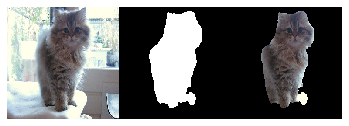

i= 2 loss= 0.4380185961298793 val_loss= 0.38489559211808705 mean_dsc= 0.8175015251860659 val_mean_dsc= 0.8427475289158199


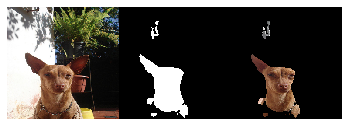

i= 3 loss= 0.3737414607550004 val_loss= 0.3931656643424345 mean_dsc= 0.8469824982674373 val_mean_dsc= 0.8378702395636103


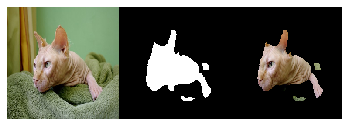

i= 4 loss= 0.3260534219422571 val_loss= 0.3260899106769458 mean_dsc= 0.8686965368072531 val_mean_dsc= 0.8620779799378436


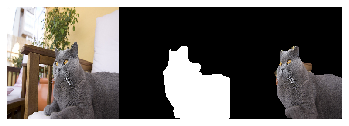

i= 5 loss= 0.30203360357345677 val_loss= 0.2978739134319451 mean_dsc= 0.8771717844865261 val_mean_dsc= 0.8766084669724755


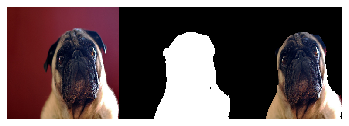

In [0]:
train_steps = len(train_files) //batch_size
test_steps = len(test_files) //batch_size
model.fit_generator(train_generator, 
                    epochs = 30, steps_per_epoch = train_steps,validation_data = test_generator, validation_steps = test_steps,
                    callbacks = build_callbacks(), verbose = 0) # verbose : 0=학습로고표시안함, 1=표시함

# Testing

In [0]:
!wget http://r.ddmcdn.com/s_f/o_1/cx_462/cy_245/cw_1349/ch_1349/w_720/APL/uploads/2015/06/caturday-shutterstock_149320799.jpg -O test.jpg

In [0]:
raw = Image.open('test.jpg')
raw = np.array(raw.resize((256, 256)))/255.
raw = raw[:,:,0:3]

#predict the mask 
pred = model.predict(np.expand_dims(raw, 0))
pred = pred[:,:,:,0]

#mask post-processing 
msk  = pred.squeeze()
msk = np.stack((msk,)*3, axis=-1)
msk[msk >= 0.5] = 1 
msk[msk < 0.5] = 0 

#show the mask and the segmented image 
combined = np.concatenate([raw, msk, raw* msk], axis = 1)
plt.axis('off')
plt.imshow(combined)
plt.show()

# References


1.   http://deeplearning.net/tutorial/unet.html
2.   https://github.com/ldenoue/keras-unet

